### Importing Libraries


In [2]:
%matplotlib inline

In [3]:
from IPython.display import Image

import pandas as pd
from pandas import DataFrame
import numpy,pickle
from numpy import load, save,append, array,percentile,hstack

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import dice,hamming,jaccard,kulsinski,matching,yule,rogerstanimoto
from scipy import stats
from scipy.stats import pointbiserialr as pointbiserial

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,MACCSkeys,AtomPairs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs,Torsions
from rdkit.Chem.AtomPairs.Torsions import GetTopologicalTorsionFingerprintAsIntVect as TopologicalTorsionFingerPrint
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
from rdkit.Chem.AtomPairs.Pairs import ExplainPairScore as ExplainAtomPairScore

#### Function calls to get fingerprint from SMILES


In [6]:
def getAtomPair(mol):
	return SimilarityMaps.GetAPFingerprint(mol, fpType='bv')

def getTopological(mol):
	return SimilarityMaps.GetTTFingerprint(mol, fpType='bv')

def getCircular(mol):
	return SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')

def getMACCS(mol):
	return MACCSkeys.GenMACCSKeys(mol)



#### Utility Functions

In [7]:
def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return load(fullPath)


def saveNumpy(obj, name, path='.'):
    if ".npy" not in name:
        fullPath = path+'/'+name
        save(fullPath, obj)
        print name,'saved successfully in',path
    else:
        fullPath = path+'/'+name.split(".npy")[0]
        save(fullPath, obj)
        print name,'saved successfully in',path
        
def loadData(name,path='.'):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)
        
def saveData(obj, name,path='.'):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)

In [8]:
data = pd.read_csv('allFunctionals.csv','|')

In [186]:
data.keys()

Index([u'Unnamed: 0', u'Unnamed: 1', u'Unnamed: 2', u'Unnamed: 3',
       u'Unnamed: 4', u'Unnamed: 5', u'Unnamed: 6', u'B3LYP', u'B3LYP.1',
       u'B3LYP.2', u'PBE', u'PBE.1', u'PBE.2', u'PB86', u'PB87', u'PB88',
       u'M06', u'M07', u'M08'],
      dtype='object')

#### Extracting SMILES From Dataset

In [84]:
SMILES = []
for SMILE in data['Unnamed: 1'][1:]:
    SMILES += [SMILE]

In [85]:
MACCS = []
AtomPair = []
Topological = []
Circular = []
mols = []
for SMILE in SMILES:
    mol = Chem.MolFromSmiles(SMILE)
    mols += [mol]
    MACCS += [numpy.transpose(getMACCS(mol))]
    AtomPair += [numpy.transpose(getAtomPair(mol))]
    Topological += [numpy.transpose(getTopological(mol))]
    Circular += [numpy.transpose(getCircular(mol))]

In [86]:
saveNumpy(mols,'mols')

mols saved successfully in .


In [46]:
saveNumpy(MACCS,'MACCS')
saveNumpy(Circular,'Circular')
saveNumpy(AtomPair,'AtomPair')
saveNumpy(Topological,'Topological')



MACCS saved successfully in .
Circular saved successfully in .
AtomPair saved successfully in .
Topological saved successfully in .


### Extracting HOMO value from Dataset 

In [87]:
HOMO = []
for item in data['B3LYP'][1:]:
    HOMO += [float(item)]

LUMO = []
for item in data['B3LYP.1'][1:]:
    LUMO += [float(item)]

GAP = []
for item in data['B3LYP.2'][1:]:
    GAP += [float(item)]

In [88]:
saveNumpy(HOMO,'HOMO')

HOMO saved successfully in .


In [89]:
saveNumpy(LUMO,'LUMO')
saveNumpy(GAP,'GAP')

LUMO saved successfully in .
GAP saved successfully in .


## <font color = "red"> Load Best Grid Search Models for Random Forest across all Fingerprints </font>

### Function for getting indices from best random forest model (grid search)

In [67]:
def getIndices(modelFile,X,Y):
        model = loadData(modelFile)['best_estimator']
        model.fit(X,Y)
        features = model.feature_importances_
        indices = numpy.argsort(features)[::-1]
        return indices

#### Getting all and top 10 features of atom pair random forest

In [146]:
atomIndices = getIndices('atomRFBest',AtomPair,HOMO)
saveNumpy(atomIndices,'atomAll','featuresRF')
saveNumpy(atomIndices[:10],'atomTop10','featuresRF')

atomAll saved successfully in featuresRF
atomTop10 saved successfully in featuresRF


In [147]:
atomIndices[:10]

array([1484, 1485, 1990,  610,  433, 1058,  551,   47, 1250, 1838])

In [22]:
atomIndicesTop = loadNumpy('atomTop10','featuresRF')
AtomPair = loadNumpy('AtomPair')

#### Getting all and top 10 features of maccs random forest

In [148]:
maccsIndices = getIndices('maccsRFBest',MACCS,HOMO)
saveNumpy(maccsIndices,'maccsAll','featuresRF')
saveNumpy(maccsIndices[:10],'maccsTop10','featuresRF')

maccsAll saved successfully in featuresRF
maccsTop10 saved successfully in featuresRF


In [149]:
maccsIndices[:10]

array([149, 141, 125,  62, 120,  49,  56,  63,  24, 163])

#### Getting all and top 10 features of topological random forest

In [150]:
topoIndices = getIndices('topoRFBest',Topological,HOMO)
saveNumpy(topoIndices,'topoAll','featuresRF')
saveNumpy(topoIndices[:10],'topoTop10','featuresRF')

topoAll saved successfully in featuresRF
topoTop10 saved successfully in featuresRF


In [151]:
topoIndices[:10]

array([1386, 1318, 1550, 1646, 1549, 1341, 1892,  434, 1340, 1645])

#### Getting all and top 10 features of circular/morgan random forest

In [152]:
circularIndices = getIndices('circularRFBest',Circular,HOMO)
saveNumpy(circularIndices,'circularAll','featuresRF')
saveNumpy(circularIndices[:10],'circularTop10','featuresRF')

circularAll saved successfully in featuresRF
circularTop10 saved successfully in featuresRF


In [153]:
circularIndices[:10]

array([1809,  162,  468,  431,  529, 1232, 1557,  717, 1963, 1370])

## <font color="blue"> Correlation Matrix (for now only AtomPair) </font>

#### Utility Functions for correlation

In [175]:
def correlationMask(X,Y,topIndices):
    length = len(X)
    d = []
    for i in range(length):
        d+= [append(X[i][topIndices],Y[i]).tolist()]
    df = pd.DataFrame(d)
    correlation = df.corr()

    # Generate a mask for the upper triangle
    mask = numpy.zeros_like(correlation, dtype=numpy.bool)
    mask[numpy.triu_indices_from(mask)] = True
    
    return correlation, mask

In [176]:
def correlationPlot(correlation,mask):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### HOMO 

In [21]:
correlationAtom = loadNumpy('correlationAtom_HOMO','correlation')
maskAtom = numpy.zeros_like(correlationAtom, dtype=numpy.bool)
maskAtom[numpy.triu_indices_from(maskAtom)] = True

In [170]:
correlation, mask = correlationMask(AtomPair,HOMO,atomIndices[:10])

#### Correlation with HOMO for top 10 features

In [171]:
correlation

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.936135,0.660907,0.038579,-0.078333,-0.064734,0.423843,0.424098,0.405209,0.029034,0.537786
1,0.936135,1.000000,0.707992,0.041210,-0.063639,-0.057165,0.382059,0.428665,0.379330,0.031014,0.541964
2,0.660907,0.707992,1.000000,0.036749,-0.046964,0.030967,0.398784,0.403983,0.425385,0.027657,0.519638
3,0.038579,0.041210,0.036749,1.000000,0.386056,0.498593,-0.016013,0.090966,0.015632,0.560532,-0.314544
4,-0.078333,-0.063639,-0.046964,0.386056,1.000000,0.301077,-0.133674,-0.048776,-0.155259,0.249956,-0.426020
5,-0.064734,-0.057165,0.030967,0.498593,0.301077,1.000000,0.067942,0.022840,0.013173,0.666540,-0.347260
6,0.423843,0.382059,0.398784,-0.016013,-0.133674,0.067942,1.000000,0.523591,0.193881,0.060680,0.433971
7,0.424098,0.428665,0.403983,0.090966,-0.048776,0.022840,0.523591,1.000000,0.171848,0.008383,0.435794
8,0.405209,0.379330,0.425385,0.015632,-0.155259,0.013173,0.193881,0.171848,1.000000,0.011765,0.454669
9,0.029034,0.031014,0.027657,0.560532,0.249956,0.666540,0.060680,0.008383,0.011765,1.000000,-0.281072


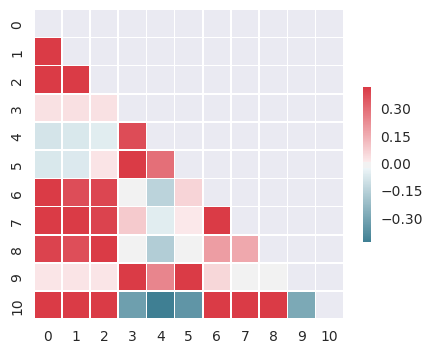

In [174]:
correlationPlot(correlation,mask)

In [183]:
saveNumpy(correlation,'correlationAtom_HOMO','correlation')

correlationAtom_HOMO saved successfully in correlation


### <font color="orange"> Extracting top features from LUMO and GAP best models </font>

##### LUMO

In [188]:
atomLUMOIndices = getIndices('LUMO_atomRFBest',AtomPair,LUMO)
saveNumpy(atomLUMOIndices,'LUMO_atomAll','featuresRF')
saveNumpy(atomLUMOIndices[:10],'LUMO_atomTop10','featuresRF')

LUMO_atomAll saved successfully in featuresRF
LUMO_atomTop10 saved successfully in featuresRF


##### GAP

In [189]:
atomGAPIndices = getIndices('GAP_atomRFBest',AtomPair,GAP)
saveNumpy(atomGAPIndices,'GAP_atomAll','featuresRF')
saveNumpy(atomGAPIndices[:10],'GAP_atomTop10','featuresRF')

GAP_atomAll saved successfully in featuresRF
GAP_atomTop10 saved successfully in featuresRF


### <font color="purple"> Correlation Matrices for LUMO and GAP </font>

##### LUMO

In [190]:
correlation, mask = correlationMask(AtomPair,LUMO,atomLUMOIndices[:10])

In [191]:
correlation

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.059832,0.126233,0.758076,0.910134,0.113576,0.074167,0.570517,0.811622,0.078403,-0.499269
1,0.059832,1.000000,-0.117790,0.045357,0.054455,0.387816,0.540898,0.034135,0.048561,0.734324,-0.409870
2,0.126233,-0.117790,1.000000,0.120115,0.109025,0.092139,-0.063365,0.090397,0.089381,-0.025058,-0.319152
3,0.758076,0.045357,0.120115,1.000000,0.832928,0.110946,0.083855,0.752587,0.934025,0.059435,-0.515082
4,0.910134,0.054455,0.109025,0.832928,1.000000,0.133200,0.100675,0.626850,0.891761,0.071357,-0.495539
5,0.113576,0.387816,0.092139,0.110946,0.133200,1.000000,0.686636,0.083497,0.118783,0.416270,-0.422234
6,0.074167,0.540898,-0.063365,0.083855,0.100675,0.686636,1.000000,0.063108,0.089778,0.613918,-0.402254
7,0.570517,0.034135,0.090397,0.752587,0.626850,0.083497,0.063108,1.000000,0.702935,0.044730,-0.440363
8,0.811622,0.048561,0.089381,0.934025,0.891761,0.118783,0.089778,0.702935,1.000000,0.063634,-0.487229
9,0.078403,0.734324,-0.025058,0.059435,0.071357,0.416270,0.613918,0.044730,0.063634,1.000000,-0.371024


In [192]:
saveNumpy(correlation,'correlationAtom_LUMO','correlation')

correlationAtom_LUMO saved successfully in correlation


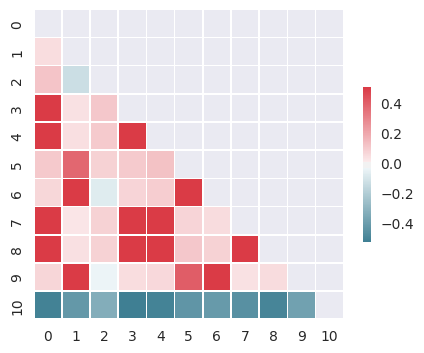

In [193]:
correlationPlot(correlation,mask)

##### GAP

In [194]:
correlation, mask = correlationMask(AtomPair,GAP,atomGAPIndices[:10])

In [195]:
correlation

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.854175,0.285141,0.934025,0.832928,0.253560,0.120115,0.842657,0.313558,0.842657,-0.639035
1,0.854175,1.000000,0.285141,0.797416,0.710375,0.253560,0.120115,0.842657,0.259300,0.842657,-0.621894
2,0.285141,0.285141,1.000000,0.305282,0.342336,0.889244,0.098248,0.240277,0.757148,0.240277,-0.567014
3,0.934025,0.797416,0.305282,1.000000,0.891761,0.271470,0.089381,0.787064,0.335706,0.787064,-0.630422
4,0.832928,0.710375,0.342336,0.891761,1.000000,0.304420,0.109025,0.701873,0.376453,0.701873,-0.630471
5,0.253560,0.253560,0.889244,0.271470,0.304420,1.000000,0.129747,0.213664,0.683832,0.213664,-0.550790
6,0.120115,0.120115,0.098248,0.089381,0.109025,0.129747,1.000000,0.101215,0.118272,0.101215,-0.379294
7,0.842657,0.842657,0.240277,0.787064,0.701873,0.213664,0.101215,1.000000,0.264222,1.000000,-0.616776
8,0.313558,0.259300,0.757148,0.335706,0.376453,0.683832,0.118272,0.264222,1.000000,0.264222,-0.572542
9,0.842657,0.842657,0.240277,0.787064,0.701873,0.213664,0.101215,1.000000,0.264222,1.000000,-0.616776


In [196]:
saveNumpy(correlation,'correlationAtom_GAP','correlation')

correlationAtom_GAP saved successfully in correlation


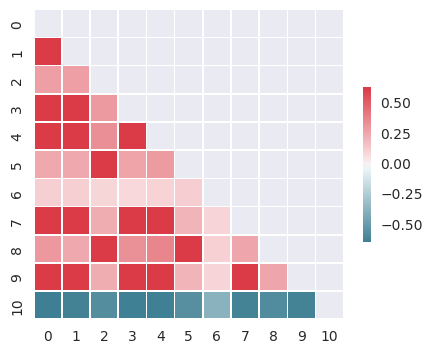

In [197]:
correlationPlot(correlation,mask)

### <font color="green">Correlation Matrices for other fingerprints (HOMO only) </font>

In [179]:
correlationMACCS, maskMACCS = correlationMask(MACCS,HOMO,maccsIndices[:10])

In [181]:
saveNumpy(correlationMACCS,'correlationMACCS_HOMO','correlation')

correlationMACCS saved successfully in correlation


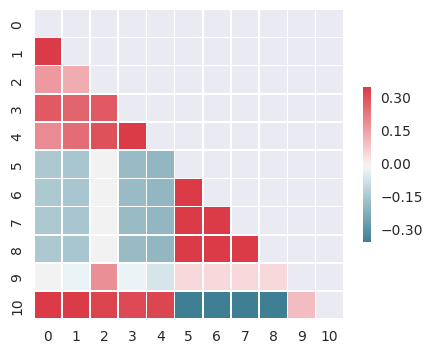

In [182]:
correlationPlot(correlationMACCS,maskMACCS)

In [180]:
correlationTopo, maskTopo = correlationMask(Topological,HOMO,topoIndices[:10])

In [184]:
saveNumpy(correlationTopo,'correlationTopo_HOMO','correlation')

correlationTopo_HOMO saved successfully in correlation


In [178]:
correlationCircular, maskCircular = correlationMask(Circular,HOMO,circularIndices[:10])

In [185]:
saveNumpy(correlationCircular,'correlationCircular_HOMO','correlation')

correlationCircular_HOMO saved successfully in correlation


### <font color="red"> Point Biserial Correlation </font>

#### HOMO 

In [26]:
PointBiserial = []
for i in range(10):
    PointBiserial +=[ pointbiserial(AtomPair_Top[i], HOMO)]
    print PointBiserial[i]

PointbiserialrResult(correlation=0.53778554279072854, pvalue=3.534850032851735e-27)
PointbiserialrResult(correlation=0.54196392230912194, pvalue=1.1808405478562514e-27)
PointbiserialrResult(correlation=0.51963758172414332, pvalue=3.4786231146715689e-25)
PointbiserialrResult(correlation=-0.31454350108442025, pvalue=2.4501074333772571e-09)
PointbiserialrResult(correlation=-0.42602002256888238, pvalue=1.3380890172497364e-16)
PointbiserialrResult(correlation=-0.34725996623345362, pvalue=3.4830665893750486e-11)
PointbiserialrResult(correlation=0.43397140953381069, pvalue=3.1307780900808911e-17)
PointbiserialrResult(correlation=0.43579433507983106, pvalue=2.2318980074442268e-17)
PointbiserialrResult(correlation=0.45466876867710582, pvalue=5.9399691666243826e-19)
PointbiserialrResult(correlation=-0.2810717900648303, pvalue=1.1493005978416246e-07)


In [27]:
saveNumpy(PointBiserial,'PointBiserialHOMO','correlation')

PointBiserialHOMO saved successfully in correlation


##### Top Indices for HOMO 

In [37]:
loadNumpy('atomTop10','featuresRF')

array([1484, 1485, 1990,  610,  433, 1058,  551,   47, 1250, 1838])

#### LUMO 

In [33]:
atomLUMOIndices = loadNumpy('LUMO_atomAll','featuresRF')
atomLUMOTopIndices = loadNumpy('LUMO_atomTop10','featuresRF')
AtomPair_Top_LUMO = []
for i in range(10):
    List = []
    for j in range(len(AtomPair)):
        List += [AtomPair[j][atomLUMOTopIndices[i]]]
    AtomPair_Top_LUMO += [List]

##### Top Indices for LUMO

In [35]:
atomLUMOTopIndices

array([1820,  433,  228,   44, 1728, 1276,   48,  548, 1989, 2041])

In [34]:
PointBiserial = []
for i in range(10):
    PointBiserial +=[ pointbiserial(AtomPair_Top_LUMO[i], LUMO)]
    print PointBiserial[i]

PointbiserialrResult(correlation=-0.49926908969685962, pvalue=4.3683154853686948e-23)
PointbiserialrResult(correlation=-0.40987041220255011, pvalue=2.2780636511537508e-15)
PointbiserialrResult(correlation=-0.31915206940893714, pvalue=1.3870918551030099e-09)
PointbiserialrResult(correlation=-0.51508169425052885, pvalue=1.0548637880716933e-24)
PointbiserialrResult(correlation=-0.4955388856147443, pvalue=1.0225385256739135e-22)
PointbiserialrResult(correlation=-0.42223439684824704, pvalue=2.6365026028767406e-16)
PointbiserialrResult(correlation=-0.40225375095844723, pvalue=8.2324890937493138e-15)
PointbiserialrResult(correlation=-0.44036283426662393, pvalue=9.4714338204752051e-18)
PointbiserialrResult(correlation=-0.48722883689830931, pvalue=6.5531305829891301e-22)
PointbiserialrResult(correlation=-0.37102379751885495, pvalue=1.1449141034443295e-12)


#### GAP

In [39]:
atomGAPTopIndices = loadNumpy('GAP_atomTop10','featuresRF')
AtomPair_Top_GAP = []
for i in range(10):
    List = []
    for j in range(len(AtomPair)):
        List += [AtomPair[j][atomGAPTopIndices[i]]]
    AtomPair_Top_GAP += [List]

In [40]:
PointBiserial = []
for i in range(10):
    PointBiserial +=[ pointbiserial(AtomPair_Top_GAP[i], GAP)]
    print PointBiserial[i]

PointbiserialrResult(correlation=-0.639034949637595, pvalue=7.053434500131388e-41)
PointbiserialrResult(correlation=-0.62189395343950515, pvalue=3.3472102094555713e-38)
PointbiserialrResult(correlation=-0.56701364552372013, pvalue=1.1828402704949364e-30)
PointbiserialrResult(correlation=-0.63042153816453494, pvalue=1.637593870513175e-39)
PointbiserialrResult(correlation=-0.63047066972502763, pvalue=1.608930898957276e-39)
PointbiserialrResult(correlation=-0.5507896204343854, pvalue=1.1072037529399253e-28)
PointbiserialrResult(correlation=-0.37929430983034368, pvalue=3.2599828150285882e-13)
PointbiserialrResult(correlation=-0.61677574044903771, pvalue=1.9589558512377913e-37)
PointbiserialrResult(correlation=-0.57254153708055666, pvalue=2.3772491900870188e-31)
PointbiserialrResult(correlation=-0.61677574044903771, pvalue=1.9589558512377913e-37)


### <font color="purple"> Similarity Scores By Transforming HOMO into Binary</font>

In [19]:
HOMO = array(HOMO)
FourthQuartileValue = percentile(HOMO,75)
HOMOBin = []
for elem in HOMO:
    if elem<FourthQuartileValue:
        HOMOBin += [0]
    else:
        HOMOBin += [1]

In [23]:
AtomPair_Top = []
for i in range(10):
    List = []
    for j in range(len(AtomPair)):
        List += [AtomPair[j][atomIndicesTop[i]]]
    AtomPair_Top += [List]

#### Jaccard Similarity 

In [16]:
Jaccard = []
for i in range(10):
    Jaccard +=[ jaccard(AtomPair_Top[i], HOMOBin)]
    print Jaccard[i]

0.732087227414
0.729559748428
0.733746130031
0.989130434783
0.982608695652
1.0
0.691729323308
0.68253968254
0.747058823529
1.0


#### Dice Similarity 

In [17]:
Dice = []
for i in range(10):
    Dice += [dice(AtomPair_Top[i], HOMOBin)]
    print Dice[i]

0.577395577396
0.574257425743
0.579462102689
0.978494623656
0.965811965812
1.0
0.528735632184
0.518072289157
0.596244131455
1.0


#### List of similarity coefficients for boolean/binary arrays
dice,jaccard,hamming,kulsinski,matching,yule,rogerstanimoto

In [18]:
Hamming = []
for i in range(10):
    Hamming += [hamming(AtomPair_Top[i], HOMOBin)]
Kulsinski = []
for i in range(10):
    Kulsinski += [kulsinski(AtomPair_Top[i], HOMOBin)]
Matching = []
for i in range(10):
    Matching += [matching(AtomPair_Top[i], HOMOBin)]
Yule = []
for i in range(10):
    Yule += [yule(AtomPair_Top[i], HOMOBin)]
Tanimoto = []
for i in range(10):
    Tanimoto += [rogerstanimoto(AtomPair_Top[i], HOMOBin)]    

In [19]:
df = DataFrame({'dice':Dice,'jaccard':Jaccard,'hamming':Hamming,'kulsinski':Kulsinski,'matching':Matching,'yule':Yule,'tanimoto':Tanimoto})
df

,dice,hamming,jaccard,kulsinski,matching,tanimoto,yule
0,0.577396,0.683140,0.732087,0.851468,0.683140,0.811744,0.000000
1,0.574257,0.674419,0.729560,0.850694,0.674419,0.805556,0.000000
2,0.579462,0.688953,0.733746,0.851979,0.688953,0.815835,0.000000
3,0.978495,0.264535,0.989130,0.997701,0.264535,0.418391,1.338583
4,0.965812,0.328488,0.982609,0.995624,0.328488,0.494530,1.683483
5,1.000000,0.264535,1.000000,1.000000,0.264535,0.418391,2.000000
6,0.528736,0.534884,0.691729,0.844697,0.534884,0.696970,0.202361
7,0.518072,0.500000,0.682540,0.844961,0.500000,0.666667,0.238392
8,0.596244,0.738372,0.747059,0.856187,0.738372,0.849498,0.000000
9,1.000000,0.261628,1.000000,1.000000,0.261628,0.414747,2.000000


In [20]:
df.to_csv('similarityVectors.csv')

### <font color="blue"> Loading and Processing 166 bit MACCS binary fingerprint csv </font>

In [134]:
maccsBin = pd.read_csv('MayaChemData/OPVMACCS.csv')

In [135]:
maccsBin['MACCS'] = ""

In [136]:
for i in range(len(maccsBin)):
    maccsBin.ix[i,'MACCS'] = maccsBin.iloc[i]['MACCSKeysFingerprints'].rsplit(';')[-1]

In [137]:
maccsBin.drop(['MACCSKeysFingerprints'],axis=1,inplace=True)

In [138]:
maccsBin.head()

,CompoundID,MACCS
0,Cmpd1,0000000000000000000010000100000000010000000000...
1,Cmpd2,0000000000000000000000000100000000010000000010...
2,Cmpd3,0000000000000000000000000100000010010000000000...
3,Cmpd4,0000000000000000000100000100010000010000000010...
4,Cmpd5,0000000000000000000000000100000000010000010010...


### <font color="green"> Loading and Processing 166 bit MACCS count fingerprint csv </font>

In [110]:
maccsCount = pd.read_csv('MayaChemData/OPV166Count.csv')
maccsCount['MACCS'] = ""
for i in range(len(maccsCount)):
    maccsCount.ix[i,'MACCS'] = maccsCount.iloc[i]['MACCSKeysFingerprints'].rsplit(';')[-1]
maccsCount.drop(['MACCSKeysFingerprints'],axis=1,inplace=True)

In [111]:
maccsCount.head()

,CompoundID,MACCS
0,Cmpd1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...
1,Cmpd2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,Cmpd3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,Cmpd4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 ...
4,Cmpd5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [9]:
maccsCount = pd.read_csv('SampleMACCS322FPCount.csv')
maccsCount['MACCS'] = ""
for i in range(len(maccsCount)):
    maccsCount.ix[i,'MACCS'] = maccsCount.iloc[i]['MACCSKeysFingerprints'].rsplit(';')[-1]
maccsCount.drop(['MACCSKeysFingerprints'],axis=1,inplace=True)

ParserError: Error tokenizing data. C error: EOF inside string starting at line 246

### <font color="brown">Writing the molecules to an SDF file to process using MayaChemTools</font>

In [98]:
w = Chem.SDWriter('OPV.sdf')

In [99]:
for i in range(344):
    w.write(mols[i])

### Comparing bit with count vectors

In [112]:
#print maccsCount.iloc[0]['MACCS'][:-1]
List = maccsCount.iloc[0]['MACCS']
newList = List.split(' ')
len(newList)
newList

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '6',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '8',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '5',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '2',
 '1',
 '5',
 '0',
 '1',
 '0',
 '0',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '19',
 '0',
 '0',
 '0',
 '0',
 '14',
 '0',
 '8',
 '0',
 '0',
 '0',
 '0',
 '9',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '8',
 '0',
 '0',
 '16',
 '0',
 '0',
 '2',
 '0',
 '0',
 '6',
 '0',
 '0',
 '2',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '8',
 '0',
 '0',
 '0',
 '2',
 '9',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '8',
 '0',
 '0',
 '2',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '1',
 '3',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '3',
 '0',
 '0',
 '1',
 '2',
 '9',
 '1']

In [113]:
print maccsBin.iloc[0]['MACCS'][:-3]
Bin = maccsBin.iloc[0]['MACCS'][:-3]
len(maccsBin.iloc[0]['MACCS']),len(maccsBin.iloc[2]['MACCS'])

000000000000000000001000010000000001000000000000011000100111110100100000100100001010000100001001001001001001000100000001000110000100000110011000010110000000001100111


(168, 168)

In [114]:
len(maccsCount.iloc[0]['MACCS'].split(' ')), len(maccsCount.iloc[-1]['MACCS'].split(' '))

(166, 166)

In [115]:
len(maccsBin.iloc[0]['MACCS'])

168

In [139]:
maccsBinary = []
for i in range(344):
    maccsBinVector = []
    for item in maccsBin.iloc[i]['MACCS']:
        maccsBinVector += [int(item)]
    maccsBinary += [maccsBinVector]

In [140]:
len(maccsBinary), len(maccsBinary[0]), len(maccsBinary[-1])

(344, 168, 168)

In [141]:
saveNumpy(maccsBinary,'maccsBinary')

maccsBinary saved successfully in .


In [117]:
maccsBin.iloc[-1]['MACCS']

'000000000000000000000001000000000100000010001000010000010000001000000110000100000000100000001100001001000001000010000010010111100100101100011111110111010001111110111000'

In [118]:
maccsCount.iloc[-1]['MACCS']

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 4 0 0 0 0 6 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 0 0 0 0 12 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 2 0 0 0 0 18 0 0 2 0 0 0 0 0 4 0 0 0 0 2 0 0 0 0 0 1 0 0 2 0 2 5 2 2 0 0 2 0 0 4 0 4 1 0 0 0 4 2 3 2 2 5 4 0 2 2 2 0 2 0 0 0 8 4 4 4 2 3 0 5 4 5 1'

In [123]:
instance = maccsCount.iloc[-1]['MACCS']
len(instance.split(' '))

166

In [124]:
maccsCountMatrix = []
for i in range(344):
    maccsCountVector = maccsCount.iloc[i]['MACCS'].split(' ')
    maccsCountList = []
    for item in maccsCountVector:
        maccsCountList += [int(item)]
    maccsCountMatrix += [maccsCountList]

In [125]:
len(maccsCountMatrix), len(maccsCountMatrix[0]), len(maccsCountMatrix[-1])

(344, 166, 166)

In [126]:
saveNumpy(maccsCountMatrix,'maccsCount')

maccsCount saved successfully in .


In [91]:
def renderDataFrame():
    maccsCount = pd.read_csv('OPV166Count.csv')
    maccsCount['MACCS'] = ""
    for i in range(len(maccsCount)):
        maccsCount.ix[i,'MACCS'] = maccsCount.iloc[i]['MACCSKeysFingerprints'].rsplit(';')[-1]
    maccsCount.drop(['MACCSKeysFingerprints'],axis=1,inplace=True)

,A,B,C,D,E
0,1.0,1.329212,NaN,-0.316280,-0.990810
1,2.0,-1.070816,-1.438713,0.564417,0.295722
2,3.0,-1.626404,0.219565,0.678805,1.889273
3,4.0,0.961538,0.104011,-0.481165,0.850229
4,5.0,1.453425,1.057737,0.165562,0.515018
5,6.0,-1.336936,0.562861,1.392855,-0.063328
6,7.0,0.121668,1.207603,-0.002040,1.627796
7,8.0,0.354493,1.037528,-0.385684,0.519818
8,9.0,1.686583,-1.325963,1.428984,-2.089354
9,10.0,-0.129820,0.631523,-0.586538,0.290720


### <font color="orange"> Extracting Atompair and Topological Fingerprint </font>

In [46]:
df = pd.read_csv('SampleTATFPSmall.csv')
df.keys()

Index([u'CompoundID', u'TopologicalAtomTorsionsFingerprints'], dtype='object')

In [47]:
df.iloc[0]['TopologicalAtomTorsionsFingerprints']

'FingerprintsVector;TopologicalAtomTorsions:AtomicInvariantsAtomTypes;42;NumericalValues;IDsAndValuesPairsString;C.X1.BO1.H3-N.X2.BO2.H1-C.X3.BO4-C.X2.BO3.H1 1 C.X1.BO1.H3-N.X2.BO2.H1-C.X3.BO4-C.X3.BO4 1 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-C.X2.BO3.H1 4 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-Cl.X1.BO1 1 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-N.X2.BO2.H1 2 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-N.X3.BO3 2 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-S.X2.BO2 2 C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4-S.X4.BO6 1 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-C.X2.BO3.H1 2 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-C.X3.BO4 1 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-F.X1.BO1 1 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-N.X2.BO2.H1 2 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-N.X3.BO3 1 C.X2.BO3.H1-C.X3.BO4-C.X3.BO4-O.X1.BO2 1 C.X2.BO3.H1-C.X3.BO4-N.X2.BO2.H1-C.X3.BO4 3 C.X2.BO3.H1-C.X3.BO4-N.X3.BO3-C.X3.BO4 4 C.X2.BO3.H1-C.X3.BO4-S.X2.BO2-C.X3.BO4 2 C.X2.BO3.H1-C.X3.BO4-S.X4.BO6-N.X2.BO2.H1 1 C.X2.BO3.H1-C.X3.BO4-S.X4.BO6-O.X1.BO2 2 C.X3.BO4-C.X2.BO3.H1-C.X2.BO3.H1-C.X3.BO4 3 C.X3.BO4-C.X2.BO3.

In [56]:
df = pd.read_csv('SimpleSampleAPFP.csv')#.iloc[0]['TopologicalAtomTorsionsFingerprints']
df.keys()

Index([u'CompoundID', u'TopologicalAtomPairsFingerprints'], dtype='object')

In [55]:
df.iloc[0]['TopologicalAtomPairsFingerprints'].rsplit(';')[-1]

'1 3 10 3 1 1 6 3 3 2 1 1 2 1 2 11 1 1 4 2 2 1 9 1 3 1 3 1 1 1 1 5 2 1 1 1 1 3 8 1 1 5 3 3 1 7 1 1 5 1 9 1 1 1 1 2 1 1 1 1 11 5 1 10 3 2 5 2 5 1 1 1 1 3 3 1 1 2 6 5 8 2 7 2 1 4 1 2 1 1 1 1 1 1 2 4 7 1 5 2 2 1 2 5 1 5 1 1 2 1 2 4 8 2 4 2 4 2 1 1 1 1 1 1 2 1 1 4 5 2 3 2 3 1 4 6 1 2 2 4 2 3 2 1 2 1 1 1 2 1 3 2 2 2 2 2 1 1 1 4 3 5 1 1 1 1 2'

In [57]:
df['fingerprint'] = ""
for i in range(len(df)):
    df.ix[i,'fingerprint'] = df.iloc[i]['TopologicalAtomPairsFingerprints'].rsplit(';')[-1]
df.drop(['TopologicalAtomPairsFingerprints'],axis=1,inplace=True)

In [63]:
a = df.iloc[0]['fingerprint']
b = df.iloc[1]['fingerprint']
c = df.iloc[-1]['fingerprint']

In [64]:
len(a.split(' ')), len(b.split(' ')),len(c.split(' '))

(167, 191, 257)